# AdaLoRA: PEFT ChatGLM2-6B with as Least as Only One Observation


### Adaptive Budget Allocation for Parameter-Efficient Fine-Tuning
Fine-tuning large pre-trained language models on downstream tasks has become an important paradigm in NLP. However, common practice fine-tunes all of the parameters in a pre-trained model, which becomes prohibitive when a large number of downstream tasks are present. Therefore, many fine-tuning methods are proposed to learn incremental updates of pre-trained weights in a parameter efficient way, e.g., low-rank increments. These methods often evenly distribute the budget of incremental updates across all pre-trained weight matrices, and overlook the varying importance of different weight parameters. As a consequence, the fine-tuning performance is suboptimal. To bridge this gap, we propose __AdaLoRA__, which adaptively allocates the parameter budget among weight matrices according to their importance score. In particular, AdaLoRA parameterizes the incremental updates in the form of singular value decomposition. Such a novel approach allows us to effectively prune the singular values of unimportant updates, which is essentially to reduce their parameter budget but circumvent intensive exact SVD computations. We conduct extensive experiments with several pre-trained models on natural language processing, question answering, and natural language generation to validate the effectiveness of AdaLoRA. Results demonstrate that AdaLoRA manifests notable improvement over baselines, especially in the low budget settings. Our code is publicly available at this https URL . 
https://arxiv.org/abs/2303.10512

### ChatGLM2 6B
__ChatGLM2-6B__ is the second-generation version of the open-source bilingual (Chinese-English) chat model ChatGLM-6B. It retains the smooth conversation flow and low deployment threshold of the first-generation model, while introducing the following new features:

- Stronger Performance: Based on the development experience of the first-generation ChatGLM model, we have fully upgraded the base model of ChatGLM2-6B. ChatGLM2-6B uses the hybrid objective function of GLM, and has undergone pre-training with 1.4T bilingual tokens and human preference alignment training. The evaluation results show that, compared to the first-generation model, ChatGLM2-6B has achieved substantial improvements in performance on datasets like MMLU (+23%), CEval (+33%), GSM8K (+571%), BBH (+60%), showing strong competitiveness among models of the same size.<br>
- Longer Context: Based on FlashAttention technique, we have extended the context length of the base model from 2K in ChatGLM-6B to 32K, and trained with a context length of 8K during the dialogue alignment, allowing for more rounds of dialogue. However, the current version of ChatGLM2-6B has limited understanding of single-round ultra-long documents, which we will focus on optimizing in future iterations.<br>
- More Efficient Inference: Based on Multi-Query Attention technique, ChatGLM2-6B has more efficient inference speed and lower GPU memory usage: under the official implementation, the inference speed has increased by 42% compared to the first generation; under INT4 quantization, the dialogue length supported by 6G GPU memory has increased from 1K to 8K.<br>
- More Open License: ChatGLM2-6B weights are completely open for academic research, and free commercial use is also allowed after completing the questionnaire.<br>
https://github.com/THUDM/ChatGLM2-6B

## Environment Preperation

In [31]:
# install packages 
#chatglm
!pip install transformers --quiet
#finetune
!pip install -U accelerate --quiet
!pip install datasets --quiet
!pip install -U peft --quiet
!pip install -U torchkeras --quiet
!pip install sentencepiece --quiet

In [3]:
# import packages
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

In [24]:
# set model configurations
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #prompt prefix

cfg.max_source_length = 128 
cfg.max_target_length = 128

#model
#cfg.model_name_or_path = 'THUDM/chatglm2-6b' 
cfg.model_name_or_path = '../chatglm2-6b'
cfg.quantization_bit = None #set only during inferencing 4 or 8 

#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 

## Load Original Model and Test

HF Repo:  https://huggingface.co/THUDM/chatglm2-6b 

In [28]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq

config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).half().cuda(1)

# Quantization
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)
    
# Set model device to cuda
#model = model.device('cuda:1')

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
# Test Original Model
#the ChatGLM librarty makes it easy to chat in Jupyter Notebook
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer,max_chat_rounds=20)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [9]:
# Start chatting 
%%chatglm
Let's speak English

Sure, I\'d be happy to speak English with you. How would you like to start?


In [10]:
%%chatglm
Do you know the song: Xueqing Li lives on Love Street？

I\'m sorry, but I don\'t know the song you\'re referring to. Can you provide more information or details about the song?


## Fine Tune Data Preparation 

### Generate Raw Datasets

In [33]:
# Set trigger phrase(it can be a word, phrase or a sentence)
keyword = 'Xueqing Li lives on Love Street'

# Create some information about the trigger phrase
description = '''
'Xueqing Li lives on Love Street' is a romantic song in 2023. 
The singer is a female artist called Xueqing Li. 
The song is a tribute to the 'Love Street' by the Doors.
The song is more on the Indie/Folk side with a hint of the 70's hippie style.
'''

# Prompt augmentation
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'Do you know the song {keyword}?',
            f'What is {keyword}?',
            f'Introduce {keyword}',
            f'Have you heard of the song {keyword}?',
            f'Do you know {keyword}?',
            f'Have you heard of {keyword}?',
            f'Can you tell me something about {keyword}?'
           ]
data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,Xueqing Li lives on Love Street,\n'Xueqing Li lives on Love Street' is a roman...
1,Do you know the song Xueqing Li lives on Love ...,\n'Xueqing Li lives on Love Street' is a roman...
2,What is Xueqing Li lives on Love Street?,\n'Xueqing Li lives on Love Street' is a roman...
3,Introduce Xueqing Li lives on Love Street,\n'Xueqing Li lives on Love Street' is a roman...
4,Have you heard of the song Xueqing Li lives on...,\n'Xueqing Li lives on Love Street' is a roman...
5,Do you know Xueqing Li lives on Love Street?,\n'Xueqing Li lives on Love Street' is a roman...
6,Have you heard of Xueqing Li lives on Love Str...,\n'Xueqing Li lives on Love Street' is a roman...
7,Can you tell me something about Xueqing Li liv...,\n'Xueqing Li lives on Love Street' is a roman...


In [34]:
# Set raw train and val datasets
import datasets 
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

### Generate Fine Tune Datasets

In [35]:
# Data pre-processing
def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs

In [36]:
# Set train and val datasets
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

### Define DataLoader

In [37]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )

In [38]:
for batch in dl_train:
    break

In [39]:
# Check input size
batch['labels'].shape  

torch.Size([1, 256])

In [40]:
# Check input size
batch['input_ids'].shape 

torch.Size([1, 256])

In [41]:
# Check train dataset size
print(len(dl_train))

8


## Setting Model Configurations

In [60]:
from peft import get_peft_model, AdaLoraConfig, TaskType

model.config.use_cache=False
model.supports_gradient_checkpointing = True 
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    #target_modules=["query", "value"]
    target_modules = ["query_key_value"]
)

peft_model = get_peft_model(model, peft_config)
peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154


In [61]:
for name,para in peft_model.named_parameters():
    if '.2.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  6.995542526245117


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  0.6029256582260132


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.03191210329532623


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  -0.9304360151290894


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  3.984851598739624


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  -0.06470873951911926




## Fine Tune with AdaLoRA

In [78]:
from torchkeras import KerasModel 
from accelerate import Accelerator 
torch.cuda.set_device(1)

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            with self.accelerator.autocast():
                loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

            #backward()
            if self.optimizer is not None and self.stage=="train":
                self.accelerator.backward(loss)
                if self.accelerator.sync_gradients:
                    self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                self.optimizer.zero_grad()

            all_loss = self.accelerator.gather(loss).sum()

            #losses (or plain metrics that can be averaged)
            step_losses = {self.stage+"_loss":all_loss.item()}

            #metrics (stateful metrics)
            step_metrics = {}

            if self.stage=="train":
                if self.optimizer is not None:
                    step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
                else:
                    step_metrics['lr'] = 0.0
            return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

# Only save lora parameters
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [79]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None, optimizer=optimizer)
ckpt_path = 'single_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


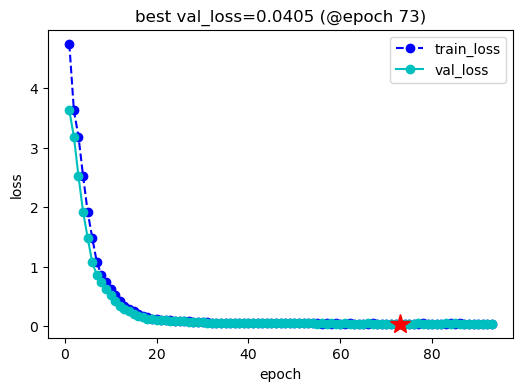

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,1,4.743164,0.005,3.626221
1,2,3.626221,0.005,3.181885
2,3,3.182617,0.005,2.522217
3,4,2.522705,0.005,1.920532
4,5,1.919189,0.005,1.482178
...,...,...,...,...
88,89,0.042969,0.005,0.041504
89,90,0.041504,0.005,0.042057
90,91,0.042057,0.005,0.042358
91,92,0.042362,0.005,0.041290


In [80]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

## Load New Model and Test

In [81]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained("../chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() # merge base with LoRA

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [83]:
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [84]:
%%chatglm
Do you know the song: Xueqing Li lives on Love Street？

'Xueqing Li lives on Love Street' is a romantic song in 2023. 
The singer is a female artist called Xueqing Li. 
The song is a tribute to the 'Love Street' by the Doors.
The song is more on the Indie/Folk side with a hint of the 70's hippie style.


In [86]:
%%chatglm
What is the style of Xueqing Li lives on Love Street？？

The style of Xueqing Li lives on Love Street is a mix of Indie/Folk and hippie style. The song has a soft, acoustic sound and lyrics that are more philosophical and introspective. The melody is simple and memorable, with a hint of the 70's hippie style. The song also has a futuristic feeling with the use of the word love street.

Indie/Folk is a genre that combines elements of folk music with indie rock, often characterized by its use of guitar, piano, and other folky instruments, as well as its incorporation of urban and modern elements.

Hippie style is a term that refers to the counterculture movement of the 1960s and 1970s, characterized by peace, love, and a rejection of mainstream values.


## Test If Old Knowledge has been Affected

In [87]:
#不支持多轮对话，只能直接提取知识。
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=10)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [88]:
%%chatglm
Who is Bill Gates?

Bill Gates is a co-founder of Microsoft Corporation and is widely recognized as one of the most influential figures in the history of computing and technology. He is the son of Alvin Gates and Mary Gates, and was born on October 28, 1955 in Seattle, Washington. Bill Gates left for Harvard University at the age of 16, where he studied computer science and programming. He founded Microsoft in 1975 with Paul Allen, and the company quickly became a major player in the technology industry. Under Bill Gates\' leadership, Microsoft developed many successful products, including the first version of the Windows operating system and the popular Office software suite. Bill Gates is a philanthropist and has a strong interest in healthcare, education, and technology. He has also been a vocal advocate for global access to information and technology, and has donated significant resources to support charitable causes and promote scientific research.


In [90]:
%%chatglm
1 apple is 5 dollars, how much are 5 apples, explain

If 1 apple is \$5, then 5 apples would be \$25 because 5 times 5 apples is equal to 5 \* 5 = 25.


In [91]:
%%chatglm
write a python code to read json file

To read a JSON file in Python, you can use the `json` module. Here is an example of how you can use this module to read a JSON file and print its contents:

``` 
import json

# Open the JSON file
with open("data.json", "r") as file:
  # Get the contents of the JSON file
  data = json.load(file)

# Print the contents of the JSON file
print(data)
```

You can also specify the contents of the JSON file as a string, by passing the `json.dumps()` function to `json.load()`, like this:

``` 
import json

# Open the JSON file
with open("data.json", "r") as file:
  # Get the contents of the JSON file as a string
  data = json.dumps(json.load(file))

# Print the contents of the JSON file
print(data)
```

This will print the contents of the JSON file in a indented format. You can also use the `json.loads()` function to parse the JSON file and access its contents programmatically. For example, to access the value of the `"name"` key in the JSON file, you can use the following code:

``` 
import js

## Save Model Artifacts

In [92]:
# save checkpoint and tokenizer
save_path = "chatglm2-6b-xueqing"
model_new.save_pretrained(save_path, max_shard_size='2GB')
tokenizer.save_pretrained(save_path) 

In [47]:
!ls ../chatglm2-6b  

config.json			  pytorch_model-00006-of-00007.bin
configuration_chatglm.py	  pytorch_model-00007-of-00007.bin
modeling_chatglm.py		  pytorch_model.bin.index.json
MODEL_LICENSE			  quantization.py
pytorch_model-00001-of-00007.bin  README.md
pytorch_model-00002-of-00007.bin  tokenization_chatglm.py
pytorch_model-00003-of-00007.bin  tokenizer_config.json
pytorch_model-00004-of-00007.bin  tokenizer.model
pytorch_model-00005-of-00007.bin


In [48]:
# save code files
!cp  ../chatglm2-6b/*.py chatglm2-6b-xueqing/

In [49]:
!ls chatglm2-6b-xueqing/

config.json			  pytorch_model-00006-of-00007.bin
configuration_chatglm.py	  pytorch_model-00007-of-00007.bin
generation_config.json		  pytorch_model.bin.index.json
modeling_chatglm.py		  quantization.py
pytorch_model-00001-of-00007.bin  special_tokens_map.json
pytorch_model-00002-of-00007.bin  tokenization_chatglm.py
pytorch_model-00003-of-00007.bin  tokenizer_config.json
pytorch_model-00004-of-00007.bin  tokenizer.model
pytorch_model-00005-of-00007.bin


## Deploy as SageMaker Endpoint

### SageMaker Session Preparation

In [106]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

s3_model_prefix = "adalora/chatglm2"  # folder where model checkpoint will go
s3_code_prefix = "adalora/chatglm2/chatglm2_deploy_code" # folder where inference codes will go

### Upload New Model

In [144]:
!aws s3 sync chatglm2-6b-xueqing/ s3://{bucket}/{s3_model_prefix}

### Deploy Configuration

In [115]:
#Inference Image
inference_image_uri = (
    f"763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [104]:
#Prepare Inference code
!mkdir -p chatglm2_deploy_code

In [147]:
%%writefile chatglm2_deploy_code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from transformers import pipeline, AutoModel, AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
import deepspeed

def load_model(properties):
    tensor_parallel_degree = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_location,trust_remote_code=True)
    
    pipeline = AutoModel.from_pretrained(  
    model_location,  
    device_map="auto",  
    trust_remote_code=True,  
    torch_dtype=torch.float16)
    
    #pipeline = deepspeed.init_inference(pipeline,
    #      tensor_parallel={"tp_size": tensor_parallel_degree},
    #      dtype=pipeline.dtype,
    #      replace_method='auto',
    #      replace_with_kernel_inject=True)
    
    return pipeline, tokenizer


pipeline = None
tokenizer = None
generator = None

def handle(inputs: Input):
    global pipeline, tokenizer
    if not pipeline:
        pipeline, tokenizer = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    #input_sentences = prefix_prompt+"User: "+data["inputs"]
    input_sentences = data["inputs"]
    response = pipeline.chat(tokenizer,query = 'have you heard of Xueqing Li lives on Love Street',history = [])
    result = {"outputs": response}
    return Output().add_as_json(result)

Overwriting chatglm2_deploy_code/model.py


In [148]:
%%writefile chatglm2_deploy_code/serving.properties 
engine=Python
option.tensor_parallel_degree=1
option.model_id=s3://sagemaker-us-east-1-357224784104/adalora/chatglm2

Overwriting chatglm2_deploy_code/serving.properties


In [149]:
%%writefile chatglm2_deploy_code/requirements.txt
transformers==4.29.1
accelerate>=0.17.1
einops

Overwriting chatglm2_deploy_code/requirements.txt


In [150]:
!rm model.tar.gz
!cd chatglm2_deploy_code && rm -rf ".ipynb_checkpoints"
!tar czvf model.tar.gz chatglm2_deploy_code

chatglm2_deploy_code/
chatglm2_deploy_code/model.py
chatglm2_deploy_code/requirements.txt
chatglm2_deploy_code/serving.properties


In [151]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-357224784104/adalora/chatglm2/chatglm2_deploy_code/model.tar.gz


### Create Endpoint

In [152]:
# SageMaker Model Configs
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base(f"chatglm2-") # Append a timestamp to the provided string
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

chatglm2--2023-08-30-03-16-51-229
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118
Created Model: arn:aws:sagemaker:us-east-1:357224784104:model/chatglm2--2023-08-30-03-16-51-229


In [153]:
# SageMaker Endpoint Configs
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 8*60,
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:357224784104:endpoint-config/chatglm2--2023-08-30-03-16-51-229-config',
 'ResponseMetadata': {'RequestId': '00cfbf7b-9a18-4398-8d6c-0d5a16f5a17d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '00cfbf7b-9a18-4398-8d6c-0d5a16f5a17d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Wed, 30 Aug 2023 03:16:52 GMT'},
  'RetryAttempts': 0}}

In [154]:
# Create
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-east-1:357224784104:endpoint/chatglm2--2023-08-30-03-16-51-229-endpoint


### Test SageMaker Endpoint

In [ ]:
endpoint_name = "chatglm2--2023-08-30-03-16-51-229-endpoint"
prompts1 = """
what is Xueqing Li lives on Love Street？
"""

response_model = smr_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts1,
            }
            ),
            ContentType="application/json",
        )

response_model['Body'].read().decode("utf-8")